In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt


torch.__version__

'2.4.1+cu118'

In [2]:
np.random.seed(123)  # Semente da aleatoriedade.
torch.manual_seed(123)  # Para os pesos da rede começar sempre iguais (BOA PRÁTICA).
torch.cuda.manual_seed(123)

baseFolder = os.path.join(os.path.dirname(os.getcwd()),"Bases")

previsoresData = os.path.join(baseFolder, "iris.csv")
df = pd.read_csv(previsoresData)  # Caracteristicas do tumor

In [3]:
df.head(5)

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<Axes: xlabel='class', ylabel='count'>

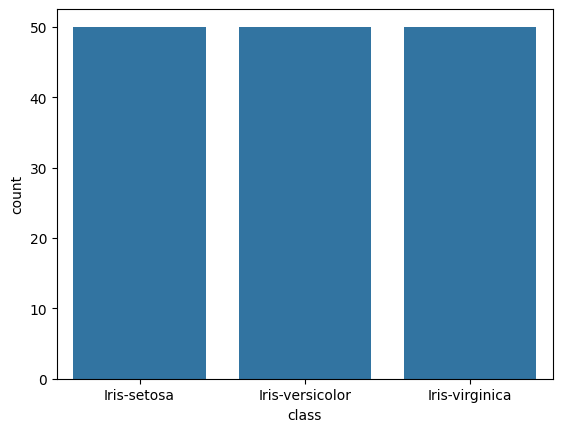

In [4]:
sns.countplot(x =df["class"])

In [5]:
previsores = df.iloc[:,0:4].values
classes = df.iloc[:,4].values
np.unique(classes)

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [6]:
encoder = LabelEncoder()  # -->  utilizada para transformar dados categóricos em números inteiros, 
classes = encoder.fit_transform(classes)
np.unique(classes)

array([0, 1, 2])

In [7]:
# Split in train and test
previsoresTreinamento, previsoresTeste, classeTreinamento, classeTeste = train_test_split(previsores, classes, test_size=.2, random_state=True)

In [8]:
previsoresTreinamento = torch.tensor(previsoresTreinamento, dtype=torch.float)
previsoresTeste = torch.tensor(previsoresTeste, dtype=torch.float)
classeTreinamento = torch.tensor(classeTreinamento, dtype=torch.long)
classeTeste = torch.tensor(classeTeste, dtype=torch.long)

In [9]:
classificador = nn.Sequential(
    nn.Linear(4,8),
    nn.ReLU(),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4,3)  # Quantidade de classes.
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classificador.parameters(), lr=0.001, weight_decay=0.0001)

In [11]:
dataSet = torch.utils.data.TensorDataset(previsoresTreinamento, classeTreinamento)
trainLoader = torch.utils.data.DataLoader(dataSet, batch_size=10, shuffle=True)

In [12]:
# Treinamento de modelo.

for epoch in range(0, 600):
    runningLoss = 0
    runningAccuracy = 0
    
    for data in trainLoader:
        inputs, labels = data 
        
        optimizer.zero_grad()  # Não ter valores anteriores no calculo atual.
        
        # outputs = previsões do BATCH SIZE
        outputs = classificador.forward(inputs)  # Passa os inputs para ter o resultado da previsão
        loss = criterion(outputs, labels)
        
        loss.backward()  # Backpropagation para fazer a atualização dos pesos.
        
        # Na nossa rede na saida não temos uma SOFTMAX para probabilidade das classe, portanto vamos colocar abaxio
        
        outputs = F.softmax(outputs)
        
        """
        Aqui, o método topk é utilizado para obter as k classes com maior probabilidade
        (neste caso, apenas a classe com maior probabilidade, já que k=1) ao longo da dimensão especificada 
        (dim=1, que representa as classes). A variável _ armazenará as probabilidades da classe mais alta, 
        enquanto topC armazenará os índices dessas classes.
        """
        _, topC = outputs.topk(k=1, dim=1)  # Classe maior probabilidade, classe
        
        # Pegamos as classes reais do dataset E COMPARAMOS COM AS PREDIÇÕES
        
        equals = topC == labels.view(*topC.shape)  # o vIEW DEIXA A MATRIZ NO MESMO FORMATO LINHA E COLUNA
        
        runningAccuracy += torch.mean(equals.type(torch.float))
        optimizer.step()
        
        runningLoss += loss.item()
    
    print(f"ÉPOCA: {epoch + 1}, {runningLoss/len(trainLoader)}, {runningAccuracy/len(trainLoader)}")

torch.save(classificador.state_dict(), "classificador_iris.pth")

C:\Users\wiwil\AppData\Local\Temp\ipykernel_4776\118646206.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs)


ÉPOCA: 1, 1.155579408009847, 0.32500001788139343
ÉPOCA: 2, 1.1371123790740967, 0.32500001788139343
ÉPOCA: 3, 1.125360091527303, 0.32500001788139343
ÉPOCA: 4, 1.1164621810118358, 0.32500001788139343
ÉPOCA: 5, 1.1075921853383381, 0.32499998807907104
ÉPOCA: 6, 1.0993644495805104, 0.32500001788139343
ÉPOCA: 7, 1.091387540102005, 0.32500001788139343
ÉPOCA: 8, 1.0819417387247086, 0.32500001788139343
ÉPOCA: 9, 1.0731941312551498, 0.32500001788139343
ÉPOCA: 10, 1.0645397553841274, 0.3333333432674408
ÉPOCA: 11, 1.0558286408583324, 0.375
ÉPOCA: 12, 1.046609232823054, 0.5
ÉPOCA: 13, 1.0374772151311238, 0.6333332657814026
ÉPOCA: 14, 1.027870347102483, 0.6749999523162842
ÉPOCA: 15, 1.018361712495486, 0.6916666030883789
ÉPOCA: 16, 1.0077612400054932, 0.6916666626930237
ÉPOCA: 17, 0.9985779772202173, 0.6916666030883789
ÉPOCA: 18, 0.987595280011495, 0.6916666626930237
ÉPOCA: 19, 0.9764153510332108, 0.6916666626930237
ÉPOCA: 20, 0.9657071481148402, 0.6916666030883789
ÉPOCA: 21, 0.9535326411326727, 0.69

In [13]:
classificador.eval()

previsoes = classificador(previsoresTeste)

previsores = [np.argmax(t) for t in previsoes.detach().numpy()]
previsores

[0,
 1,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 2]

<Axes: >

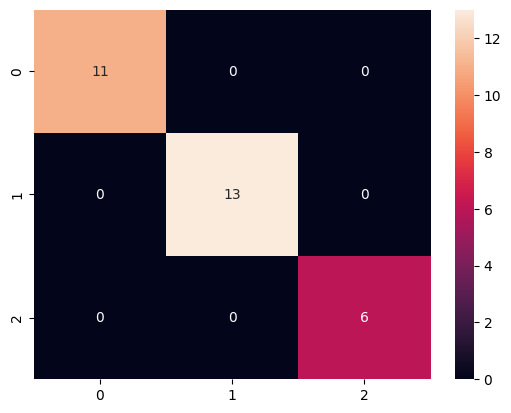

In [14]:
matriz = confusion_matrix(previsores, classeTeste)
sns.heatmap(matriz, annot=True)